# LDA Topic Modeling for EV Patents  
Contributor: Claire Yuen

In [1]:
import json
import numpy as np
import pandas as pd
from pprint import pprint

#spacy for lemmatization
import spacy
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
# Read the file
import json
from tqdm.autonotebook import tqdm
# Change the directory
f = open("patent_information_35000.json")
# returns JSON object as a dictionary
patent_dict = json.load(f)
f.close()

# Define queries and documents 
queries = patent_dict[:800]
docs = patent_dict[800:]


## Extract information 
def extract_information_patent(docs):
    patent_nums, title, abstract, title_and_abs, body = [], [], [], [], []
    citation = {}
    patent_index2id = {}
    patent_id2index = {}
    #doc_index2id = {}
    # Obtain all titles, abstracts, citations 
    for index, patent in enumerate(tqdm(docs)):
        patent_num = patent['patent']
        patent_nums.append(patent_num)
        citation[patent_num] = [num['patent_number'] for num in patent['patent_citations']]
        titl = patent['title']
        abs = patent['abstract_text']
        title.append(titl)
        abstract.append(abs)
        title_and_abs.append(titl+'[SEP]'+abs)
        body.append(patent['body_message'])
        
        # Create index to id for querys and documents
        patent_index2id[index] = patent_num
        patent_id2index[patent_num] = index
    return patent_nums, title, abstract, title_and_abs, body, citation, patent_index2id, patent_id2index

# Run the function
patent_q, title_q, abstract_q, title_and_abs_q, body_q, _, _, _ = extract_information_patent(queries)
patent, title, abstract, title_and_abs, body, citation, patent_index2id, patent_id2index = extract_information_patent(docs)


## Until here 

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/34200 [00:00<?, ?it/s]

In [3]:
abstract_q.extend(abstract)
len(abstract_q)

35000

In [4]:
patent_q.extend(patent)
len(patent_q)

35000

In [5]:
def sentence_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

data_words = list(sentence_to_words(abstract_q))
print(data_words[:1])

[['an', 'electric', 'vehicle', 'includes', 'battery', 'charging', 'lid', 'vehicle', 'side', 'charging', 'connector', 'contactor', 'contactor', 'welding', 'detector', 'dc', 'inlet', 'cover', 'dc', 'lock', 'mechanism', 'and', 'lock', 'controller', 'the', 'battery', 'is', 'to', 'be', 'charged', 'with', 'power', 'supplied', 'from', 'an', 'external', 'power', 'supply', 'the', 'vehicle', 'side', 'charging', 'connector', 'is', 'disposed', 'inside', 'position', 'of', 'the', 'charging', 'lid', 'in', 'the', 'electric', 'vehicle', 'and', 'includes', 'an', 'ac', 'inlet', 'for', 'ac', 'charging', 'and', 'dc', 'inlet', 'for', 'dc', 'charging', 'the', 'contactor', 'is', 'provided', 'on', 'power', 'line', 'connecting', 'the', 'dc', 'inlet', 'to', 'the', 'battery', 'the', 'contactor', 'welding', 'detector', 'is', 'configured', 'to', 'detect', 'welding', 'of', 'the', 'contactor', 'the', 'dc', 'inlet', 'cover', 'covers', 'the', 'dc', 'inlet', 'without', 'covering', 'the', 'ac', 'inlet', 'in', 'state', 'w

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [7]:
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)
bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(texts):
    return [bigram[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# lemmatization to keep noun, adj, vb, adv
data_processed = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_processed[:1])

[['electric', 'vehicle', 'include', 'battery', 'charge', 'lid', 'vehicle', 'side', 'charge', 'connector', 'contactor', 'contactor', 'welding', 'detector', 'dc', 'inlet', 'cover', 'lock', 'mechanism', 'lock', 'controller', 'battery', 'charge', 'power', 'supply', 'external', 'power', 'supply', 'vehicle', 'side', 'charge', 'connector', 'dispose', 'position', 'charge', 'lid', 'electric', 'vehicle', 'include', 'charge', 'inlet', 'charge', 'contactor', 'provide', 'power', 'line', 'connect', 'inlet', 'battery', 'contactor', 'welding', 'detector', 'configure', 'detect', 'welding', 'contactor', 'inlet', 'cover', 'cover', 'inlet', 'cover', 'cover', 'close', 'state', 'lock', 'mechanism', 'lock', 'dc', 'inlet', 'cover', 'close', 'state']]


In [10]:
#Dictionary
id2word = corpora.Dictionary(data_processed)

#Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]


In [11]:
def calculate_coherence_score(id2word, corpus, texts, topic_limit, start, step):
    coherence_score_list=[]
    for number_topic in range(start, topic_limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=number_topic, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        coherence_score=CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_score_list.append(coherence_score.get_coherence())
    return coherence_score_list

coherence_score_list = calculate_coherence_score(id2word, corpus, data_processed, topic_limit=10, start=1, step=1)

In [12]:
for i in range(len(coherence_score_list)):
    print('Number of Topic:', i+1,' with Coherence score:',coherence_score_list[i])
#Number of Topic: 4  should be used since its coherence score is the highest

Number of Topic: 1  with Coherence score: 0.2663214709723226
Number of Topic: 2  with Coherence score: 0.4383449201216673
Number of Topic: 3  with Coherence score: 0.5089643462897772
Number of Topic: 4  with Coherence score: 0.4632273327029416
Number of Topic: 5  with Coherence score: 0.5051539997416288
Number of Topic: 6  with Coherence score: 0.4478200983677685
Number of Topic: 7  with Coherence score: 0.43793285342192023
Number of Topic: 8  with Coherence score: 0.48876593074429164
Number of Topic: 9  with Coherence score: 0.4277387735522585


In [13]:
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

## The keywords for each topic and The weightage of each keyword

In [14]:
pprint(optimal_lda_model.print_topics())
# 1:5 cul, 0:3, 2:1, 3:2, 4:4 

[(0,
  '0.061*"vehicle" + 0.049*"first" + 0.037*"second" + 0.030*"unit" + '
  '0.028*"drive" + 0.028*"control" + 0.026*"electric" + 0.021*"motor" + '
  '0.020*"energy" + 0.018*"include"'),
 (1,
  '0.097*"power" + 0.062*"charge" + 0.051*"battery" + 0.038*"current" + '
  '0.036*"circuit" + 0.034*"voltage" + 0.027*"source" + 0.027*"value" + '
  '0.026*"storage" + 0.022*"supply"'),
 (2,
  '0.044*"device" + 0.031*"system" + 0.025*"vehicle" + 0.021*"signal" + '
  '0.019*"include" + 0.014*"receive" + 0.014*"method" + 0.014*"least" + '
  '0.013*"control" + 0.013*"display"'),
 (3,
  '0.035*"user" + 0.021*"datum" + 0.020*"information" + 0.018*"system" + '
  '0.014*"use" + 0.013*"network" + 0.012*"input" + 0.012*"set" + '
  '0.012*"provide" + 0.011*"computer"'),
 (4,
  '0.022*"battery" + 0.019*"include" + 0.018*"portion" + 0.013*"module" + '
  '0.013*"cell" + 0.013*"position" + 0.013*"form" + 0.013*"element" + '
  '0.011*"body" + 0.011*"cool"')]


In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_lda_model, corpus, id2word, mds="mmds", R=10)
vis

/Users/claireyuen/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/claireyuen/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/claireyuen/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/claireyuen/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/claireyuen/opt

/Users/claireyuen/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/claireyuen/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/claireyuen/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/claireyuen/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/claireyuen/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Ve

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.317733  0.003633       1        1  33.282049
3      0.180596  0.313494       2        1  24.124727
0     -0.270944 -0.156120       3        1  17.864480
4     -0.302673  0.269091       4        1  15.299319
1      0.075289 -0.430097       5        1   9.429425, topic_info=          Term          Freq         Total Category  logprob  loglift
22       power  21976.000000  21976.000000  Default  10.0000  10.0000
27     vehicle  38291.000000  38291.000000  Default   9.0000   9.0000
299      first  17521.000000  17521.000000  Default   8.0000   8.0000
1       charge  11686.000000  11686.000000  Default   7.0000   7.0000
0      battery  16124.000000  16124.000000  Default   6.0000   6.0000
..         ...           ...           ...      ...      ...      ...
174  converter   1973.408880   1974.243200   Topic5  -4.5572   2.3609
22       power  18179.677389  21976.611637   Topic5  -2.3366   2.1717
26      supply   4217.889809   4813.749025   Topic5  -3.7976   2.2292
178     source   5036.387188   6061.563745   Topic5  -3.6203   2.1761
0      battery   9535.219919  16124.885325   Topic5  -2.9820   1.8360

[90 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
725       2  0.999837       access
100       2  0.999924  application
0         4  0.408623      battery
0         5  0.591322      battery
410       4  0.999708         body
...     ...       ...          ...
27        3  0.564246      vehicle
27        4  0.006059      vehicle
839       5  0.999852      voltage
371       3  0.999879        wheel
468       1  0.999928     wireless

[106 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

In [16]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_processed):

    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', '%_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_lda_model, corpus=corpus, texts=data_processed)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', '%_Contribution', 'Keywords', 'Text']

/var/folders/2c/tbg6zvgs1xqftmv1wbb0g1vw0000gn/T/ipykernel_2128/2967583247.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/2c/tbg6zvgs1xqftmv1wbb0g1vw0000gn/T/ipykernel_2128/2967583247.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [37]:
def extract_contributor(docs):
    inventors, asignees=[], []
    for index, patent in enumerate(tqdm(docs)):
        i=[]
        a=[]
        for inventor in patent['inventor_name']:
            i.append(inventor['inventor_name'])
        inventors.append(i)
        for asignee in patent['assignee_name_orig']:
            a.append(asignee['assignee_name'])
        asignees.append(a)
    return inventors,asignees
inventors_q, asignees_q = extract_contributor(queries)
inventors, asignees = extract_contributor(docs)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/34200 [00:00<?, ?it/s]

In [40]:
inventors_q.extend(inventors)

In [41]:
asignees_q.extend(asignees)

## The dominant topic of each patent

In [72]:
# df_dominant_topic_patent=df_dominant_topic.drop(['Document_No'], axis=1)
# df_dominant_topic_patent.head(10)
df_dominant_topic.head()

,Patent_id,Dominant_Topic,%_Contribution,Keywords,Text
0,US9533588B2,4,0.5293,"battery, include, portion, module, cell, posit...","[electric, vehicle, include, battery, charge, ..."
1,US9987944B2,4,0.3137,"battery, include, portion, module, cell, posit...","[vehicle, include, electric, machine, arrange,..."
2,US10071639B2,0,0.4406,"vehicle, first, second, unit, drive, control, ...","[charge, system, electric, vehicle, provide, i..."
3,US9929440B2,2,0.3867,"device, system, vehicle, signal, include, rece...","[vehicle, propulsion, system, comprise, plural..."
4,US10486690B2,0,0.9143,"vehicle, first, second, unit, drive, control, ...","[system, method, provide, hybrid, electric, in..."


In [74]:
df_dominant_topic_patent=df_dominant_topic

## The most representative patent of each topic

In [75]:
df_represent_doc = df_dominant_topic_patent.loc[df_dominant_topic_patent.groupby('Dominant_Topic')['%_Contribution'].idxmax()].reset_index(drop=True)
df_represent_doc

,Patent_id,Dominant_Topic,%_Contribution,Keywords,Text
0,US9435415B2,0,0.9603,"vehicle, first, second, unit, drive, control, ...","[electric, motor, vehicle, comprise, first, ge..."
1,DE102014200427A1,1,0.9850,"power, charge, battery, current, circuit, volt...","[eine, mit_einer, achse, ersten, antriebseinhe..."
2,US20150045983A1,2,0.9904,"device, system, vehicle, signal, include, rece...","[certain, embodiment, disclosure, include, met..."
3,US20060287865A1,3,0.9875,"user, datum, information, system, use, network...","[establish, multimodal, application, voice, in..."
4,US20170144706A1,4,0.9898,"battery, include, portion, module, cell, posit...","[vehicle, frame, structure, include, elongate,..."


In [76]:
df_doc_distribution = df_dominant_topic_patent.groupby(['Dominant_Topic'])['Patent_id'].count()
df_doc_distribution = pd.DataFrame(df_doc_distribution)
df_doc_distribution = df_doc_distribution.rename(columns={'Patent_id': "Number_doc"})
df_doc_distribution['percentage'] = (df_doc_distribution['Number_doc'] / df_doc_distribution['Number_doc'].sum()) * 100
extracted_col = df_represent_doc["Keywords"]
df_doc_distribution = df_doc_distribution.join(extracted_col)
df_doc_distribution

,Number_doc,percentage,Keywords
Dominant_Topic,,,
0,5662,16.177143,"vehicle, first, second, unit, drive, control, ..."
1,5222,14.920000,"power, charge, battery, current, circuit, volt..."
2,11673,33.351429,"device, system, vehicle, signal, include, rece..."
3,7552,21.577143,"user, datum, information, system, use, network..."
4,4891,13.974286,"battery, include, portion, module, cell, posit..."


## Topic distribution

<AxesSubplot:title={'center':'Topic Distrubution'}, ylabel='percentage'>

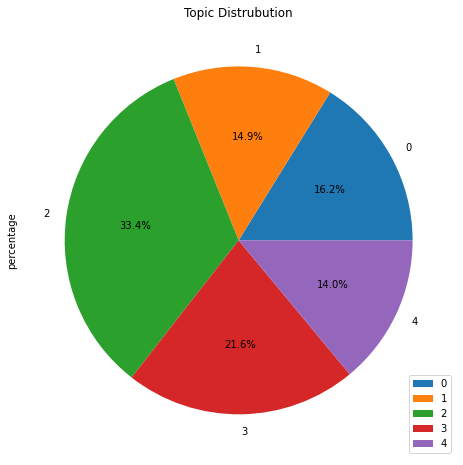

In [77]:
# plot = df_doc_distribution.plot.pie(y='percentage', figsize=(8, 8))
# plot

df_doc_distribution.plot.pie(title="Topic Distrubution",y='percentage',autopct='%1.1f%%', figsize=(8, 8))

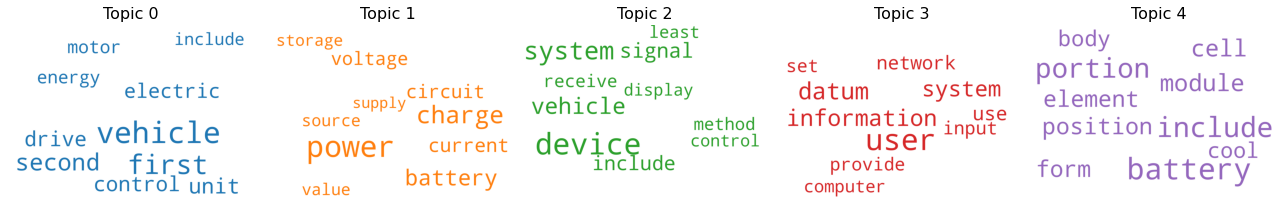

In [78]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(18,18), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Contributor Analysis

In [89]:
df_dominant_topic=df_dominant_topic.drop(['assignee_name'], axis=1)

In [92]:
df_dominant_topic_inventor=df_dominant_topic
df_dominant_topic_inventor.head()

,Patent_id,inventor_name,Dominant_Topic,%_Contribution,Keywords,Text
0,US9533588B2,"[Hakaru SADANO, Hiroyuki Kanazawa]",4,0.5293,"battery, include, portion, module, cell, posit...","[electric, vehicle, include, battery, charge, ..."
1,US9987944B2,"[Brock Dunlap, Bryan Michael Bolger, Angel Fer...",4,0.3137,"battery, include, portion, module, cell, posit...","[vehicle, include, electric, machine, arrange,..."
2,US10071639B2,"[Jeong Bin Yim, Jae Hwa Jeon, Dae Woong Han, S...",0,0.4406,"vehicle, first, second, unit, drive, control, ...","[charge, system, electric, vehicle, provide, i..."
3,US9929440B2,"[Ann Marie Sastry, Fabio Albano, Chia-Wei Wang...",2,0.3867,"device, system, vehicle, signal, include, rece...","[vehicle, propulsion, system, comprise, plural..."
4,US10486690B2,"[David Colavincenzo, Fernando VENEGAS DIAZ]",0,0.9143,"vehicle, first, second, unit, drive, control, ...","[system, method, provide, hybrid, electric, in..."


In [120]:
df_dominant_topic_inventor=df_dominant_topic_inventor.explode('inventor_name')
df_dominant_topic_inventor.head()

,Patent_id,inventor_name,Dominant_Topic,%_Contribution,Keywords,Text
0,US9533588B2,Hakaru SADANO,4,0.5293,"battery, include, portion, module, cell, posit...","[electric, vehicle, include, battery, charge, ..."
0,US9533588B2,Hiroyuki Kanazawa,4,0.5293,"battery, include, portion, module, cell, posit...","[electric, vehicle, include, battery, charge, ..."
1,US9987944B2,Brock Dunlap,4,0.3137,"battery, include, portion, module, cell, posit...","[vehicle, include, electric, machine, arrange,..."
1,US9987944B2,Bryan Michael Bolger,4,0.3137,"battery, include, portion, module, cell, posit...","[vehicle, include, electric, machine, arrange,..."
1,US9987944B2,Angel Fernando Porras,4,0.3137,"battery, include, portion, module, cell, posit...","[vehicle, include, electric, machine, arrange,..."


In [141]:
df_inventor_top = df_inventor_distribution.loc[df_inventor_distribution.groupby('Dominant_Topic')['Patent_id'].transform('max').eq(df_inventor_distribution['Patent_id'])]
df_inventor_top.columns = df_inventor_top.columns.str.replace('Patent_id', 'count')
df_inventor_top

,Dominant_Topic,inventor_name,count
6342,0,Robert Dean King,69
15475,1,Shinji Ichikawa,48
28029,2,Christopher P. Ricci,134
53297,3,Jerome R. Bellegarda,42
68465,4,Niall R. Lynam,78


In [ ]:
df_dominant_topic.drop(['Document_No'], axis=1)

In [127]:
df_dominant_topic_asignee=df_dominant_topic.drop(['inventor_name'], axis=1)
df_dominant_topic_asignee

,Patent_id,Dominant_Topic,%_Contribution,Keywords,Text
0,US9533588B2,4,0.5293,"battery, include, portion, module, cell, posit...","[electric, vehicle, include, battery, charge, ..."
1,US9987944B2,4,0.3137,"battery, include, portion, module, cell, posit...","[vehicle, include, electric, machine, arrange,..."
2,US10071639B2,0,0.4406,"vehicle, first, second, unit, drive, control, ...","[charge, system, electric, vehicle, provide, i..."
3,US9929440B2,2,0.3867,"device, system, vehicle, signal, include, rece...","[vehicle, propulsion, system, comprise, plural..."
4,US10486690B2,0,0.9143,"vehicle, first, second, unit, drive, control, ...","[system, method, provide, hybrid, electric, in..."
...,...,...,...,...,...
34995,US20080218491A1,2,0.6320,"device, system, vehicle, signal, include, rece...","[interface, electronic, apparatus, include, to..."
34996,US20120195087A1,2,0.3748,"device, system, vehicle, signal, include, rece...","[apparatus, include, inverter, include, high, ..."
34997,US20120083948A1,1,0.3359,"power, charge, battery, current, circuit, volt...","[vehicle, include, first, second, battery, pac..."
34998,US6131019A,2,0.7330,"device, system, vehicle, signal, include, rece...","[vehicle, communication, system, include, conn..."


In [128]:
df_dominant_topic_asignee.insert(1, 'assignee_name', asignees_q)

In [132]:
df_dominant_topic_asignee=df_dominant_topic_asignee.explode('assignee_name')
df_dominant_topic_asignee.head()

,Patent_id,assignee_name,Dominant_Topic,%_Contribution,Keywords,Text
0,US9533588B2,Honda Motor Co Ltd,4,0.5293,"battery, include, portion, module, cell, posit...","[electric, vehicle, include, battery, charge, ..."
1,US9987944B2,Ford Global Technologies LLC,4,0.3137,"battery, include, portion, module, cell, posit...","[vehicle, include, electric, machine, arrange,..."
2,US10071639B2,Hyundai Motor Co,0,0.4406,"vehicle, first, second, unit, drive, control, ...","[charge, system, electric, vehicle, provide, i..."
3,US9929440B2,Sakti3 Inc,2,0.3867,"device, system, vehicle, signal, include, rece...","[vehicle, propulsion, system, comprise, plural..."
4,US10486690B2,Bendix Commercial Vehicle Systems LLC,0,0.9143,"vehicle, first, second, unit, drive, control, ...","[system, method, provide, hybrid, electric, in..."


In [137]:
df_asignee = df_dominant_topic_asignee.groupby(['Dominant_Topic','assignee_name'])['Patent_id'].agg('count').reset_index()
df_asignee.head()

,Dominant_Topic,assignee_name,Patent_id
0,0,"""polymagnet Nw"" LLC",1
1,0,101070291 Saskatchewan Ltd.,1
2,0,814405 Ontario Ltd,1
3,0,8D Technologies ULC,1
4,0,A123 Systems Inc,4


In [140]:
df_asignee_top = df_asignee.loc[df_asignee.groupby('Dominant_Topic')['Patent_id'].transform('max').eq(df_asignee['Patent_id'])]
df_asignee_top.columns = df_asignee_top.columns.str.replace('Patent_id', 'count')
df_asignee_top

,Dominant_Topic,assignee_name,count
1805,0,Toyota Motor Corp,472
3537,1,Toyota Motor Corp,431
4449,2,Apple Inc,268
10118,3,International Business Machines Corp,418
12642,4,Ford Global Technologies LLC,144
